#Adaptable Deep Learning Model for Artistic Style Transfer

This task is inspired from the paper "**A Neural Algorithm of Artistic Style**" where Neural Style Transfer was first outlined. We adapt the techniques highlighted in the paper to suit our style dataset and content image, and then apply various modifications that are inspired from our own understanding of the subject and inspiration from few other research works.

[**A Neural Algorithm of Artistic Style**](https://arxiv.org/pdf/1508.06576.pdf) <br>
<br>

For the code implementation, we have referred to **tensorflow tutorials** for Neural Style tranfer. It can be accessed [here](https://www.tensorflow.org/tutorials/generative/style_transfer).
<br>
<br>

I have **documented my progress** in this task over 2 days in this [Google Doc](https://docs.google.com/document/d/1398eeXx16g9dlEWAKq-J3oK-iT1ju6ES5Nnnjr7TGvM/edit?usp=sharing), which can be referred to better understand the flow of thoughts throughout the process of research and implementation. It also highlights ideas for future modifications, which will be elaborated upon in the last section.
<br>
<br>
Thank you for this interesting task!


#Importing Dependencies

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

#Data Collection

We obtain the data from "**The best Artworks of all time**" dataset from Kaggle, containing a collection of artworks of the 50 most influential artists of all time. Here, we choose the painting by "**Alfred Sisley**", a predominently impressionist landscape painter from France. I chose his paintings as they had a distinct texture and colour style, which was easy to identify and made visual comparison and interpretation of model results easy.


[Kaggle dataset](https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time)

**Alfred Sisley**

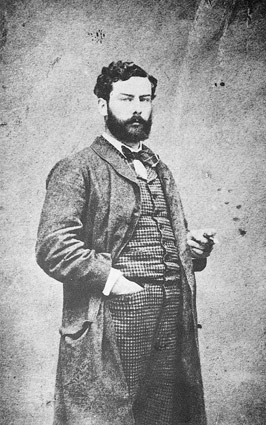

Some paintings:


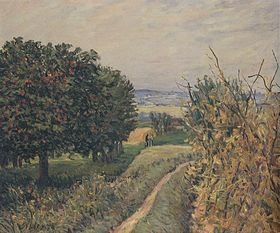
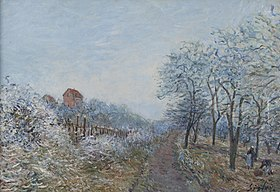

##Downloading data from kaggle (only applicable for Google Colab)

*Please use a kaggle.json. Please upload the same locally on colab. cp command copies the credentials file from the local directory in colab to the root directory. The kaggle API reads the information from the root directory by default*

In [4]:
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [5]:
# ! kaggle datasets download -d ikarus777/best-artworks-of-all-time

 99% 2.27G/2.29G [00:20<00:00, 129MB/s]
100% 2.29G/2.29G [00:20<00:00, 121MB/s]


In [ ]:
# ! unzip best-artworks-of-all-time

##Content Image
*As content image(the image to stylize), we have chosen a standard landscape photograph with vibrant colours. This contrasts with the mellow and faded drawing style of Alfred Sisley, and gives us a good metric for comparison*

**Image:** <br>
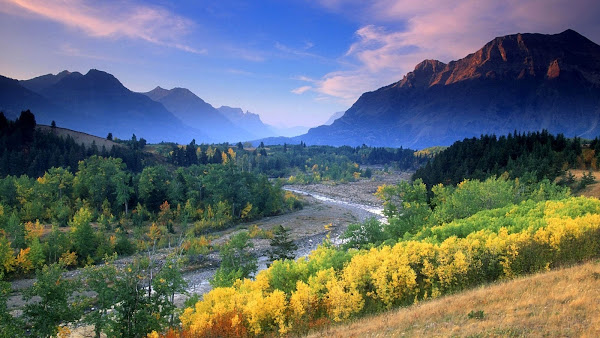

In [7]:
content_path = tf.keras.utils.get_file('landscape.jpg', 'https://4.bp.blogspot.com/-byVtxeztjWU/VSfUWgLlzkI/AAAAAAACjO8/O_tp21BCk9I/s600/landscape.jpg')

88980/88980 [==============================] - 0s 0us/step


#Data Preprocessing

##Helper Functions

In [8]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [9]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [10]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

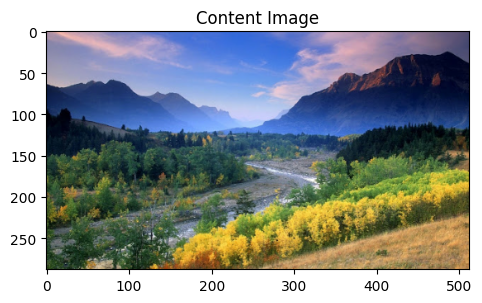

In [11]:
content_image = load_img(content_path)
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

#Model Architecture

##Define Content and Style Representation

*For this task, we use a **pretrained CNN architecture:** **VGG-network**. This is a Convolutional Neural Network that rivals human performance on common visual object recognition benchmark tasks. We do not use any of the fully connected layers(include_top=False). Avg Pooling is used instead of max pooling to providing smoother images.*

In [12]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 0s 0us/step

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


**Content Layers:** For the content representation we use the block5_conv2. This is because higher layers in the network capture the high-level content in terms of objects and their arrangement in the input image and do not constrain the exact pixel values of the reconstruction. <br> <br>
**Style layers**: For the style layers, we use 5 convolution layers, one from each block. As we will see ahead, we take a Gram Matrix(nothing but a style reprentation) from each of these layers and this in totality represents the style of the image. We can give differential weighting to the Gram Matrix from each layer depending on what element of the image style we want to lay greater emphasis on. As a thumb rule, higher layers represent high level arrangements and not pixel-wise distributions


In [13]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

##Building the model

Function "vgg_layers" provides output of the list of layers it is provided with, relevant for us to calculate our style and content vector

In [14]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

##Calculating Style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [15]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

##Extracting Style

**StyleContentModel** is a class, given content and style layer inputs, initializes an extractor that provides style gram matrices and content convolution layer(block5_conv2) output layer of a given content image in respective dictionary keys.

In [16]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

This is the output of the style and content features of our content image

In [17]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()


print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.014120049
    max:  11732.873
    mean:  646.4285

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  127497.016
    mean:  14647.494

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0748038
    max:  407685.25
    mean:  13435.203

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  8563923.0
    mean:  221648.88

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  133255.5
    mean:  1522.5027

Contents:
   block5_conv2
    shape:  (1, 18, 32, 512)
    min:  0.0
    max:  1324.1472
    mean:  14.497456


##Defining Style, Content targets and Loss Function

Here, we loop over all the images of Alfred Sisley available in our dataset and storing the extracted style features of each image in a list of dictionaries

In [18]:
from tqdm import tqdm
input_dir = "/content/images/images/Alfred_Sisley"
matrices = []
for filename in tqdm(os.listdir(input_dir)):
  input_path = os.path.join(input_dir, filename)
  image = load_img(input_path)
  # print(image.shape)
  gram = extractor(image)['style']
  matrices.append(gram)

print(len(matrices))

100%|██████████| 259/259 [01:04<00:00,  4.04it/s]

259


**Naive Approach:** Initially, we try to use the average of the style features of the images of the artist as the **style_target**. Here we add tensors of a given layer and average it to get a final representative Style_Target.

In [19]:
style_targets = {}
for key in matrices[0].keys():
  x = 0
  for i in range(len(matrices)):
    x += matrices[i][key]
  style_targets[key] = x/len(matrices)

print(style_targets)

{'block1_conv1': <tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[1910.2396  ,  477.2441  ,  537.8334  , ...,  808.892   ,
          572.9158  ,  932.7636  ],
        [ 477.2441  , 2125.0842  , 1463.5001  , ...,  113.592415,
          382.26166 ,  680.45013 ],
        [ 537.8334  , 1463.5001  , 1230.8911  , ...,   62.480133,
          466.8204  ,  814.3811  ],
        ...,
        [ 808.892   ,  113.592415,   62.480133, ..., 4739.5146  ,
          583.936   ,  375.26074 ],
        [ 572.9158  ,  382.26166 ,  466.8204  , ...,  583.936   ,
         1076.3875  , 1003.0482  ],
        [ 932.7636  ,  680.45013 ,  814.3811  , ...,  375.26074 ,
         1003.0482  , 1294.2487  ]]], dtype=float32)>, 'block2_conv1': <tf.Tensor: shape=(1, 128, 128), dtype=float32, numpy=
array([[[1.7222906e+02, 3.5072067e+01, 1.0944408e+00, ...,
         1.5136308e+02, 9.1369034e+01, 4.4474583e+01],
        [3.5072067e+01, 1.8696156e+04, 9.3918252e+03, ...,
         1.9361375e+04, 8.7930498e+03, 8.9

Content image is loaded into a variable "image" to begin optimization. We also load the content features of the content image as content targets.

In [20]:
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1

In [21]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Load the adam optimiser and initialize the style and content weights

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [23]:
style_weight=1e-2
content_weight=1e4

We use a style content loss function which strikes a balance between style emulation and content preservation. For this, we calculate seperately the *style_loss* and the *content_loss*.
1. **Style Loss:** Mean Squared Error of the difference between the gram matrices produced for each style layer for the generated image and our style_target. This is normalised over the number of style layers as it is added to content loss.
2. **Content Loss:** Mean Squared Error of the difference between the content features produced for the generated image and our content_target

We use style and content weights of 1e-2 and 1e4 respectively for adding them.

In [24]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

We use the above formulated loss for running gradient descent with our optimiser

In [25]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

#Running Gradient descent

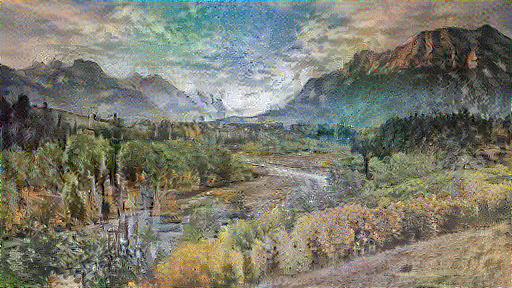

Train step: 1000
Total time: 61.1


In [26]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

 As we can see, the result of this training iteration has produced a sharp image with too many **noisy artifacts**. In the following iterations, we attempt to: <br> (1) **Change the loss function** and (2) **Change** the style and content **weight initialization**


#Modification 1: Changing loss function to Mean Squared Error

As an improvement on the Naive approach which results in lot of information loss for the style from the artpieces of the artist, we use the standard Mean **Squared Error Approach (MSE)** which takes the squared error with all the images and their style targets, normalises it and minimises it. The result of the image generated with this is as follows:

In [27]:
def mse_style_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = 0
    for i in range(len(matrices)):
      style_loss += tf.add_n([tf.reduce_mean((style_outputs[name]-matrices[i][name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight /( num_style_layers * len(matrices))

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

In [29]:
@tf.function()
def mse_train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = mse_style_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

##Re-running the Optimization

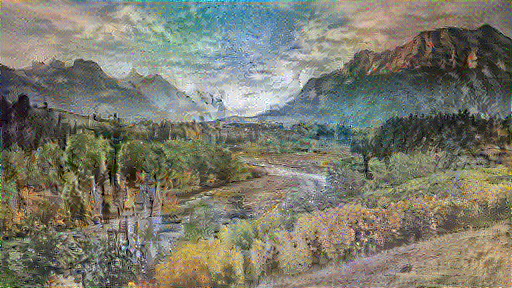

Train step: 1000
Total time: 113.1


In [30]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    mse_train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

We see no significant improvement in image quality in this approach compared to the average gram matrix style target

#Modification 2: Changing loss function to Mean Absolute Error

The MSE works in the premise that outliers in the training set which are far from the prediction are to be penalised more than the data points near our prediction. This is not what we require as we want to match the style of our generated image with the art most similar to it. In this case, we actually want to not give importance to outlier styles in the artist's works. So, we use **Mean Absolute Error(MAE)** as an alternative. As the error values will be much lesser, we increase the style weight from 1e-2 to 1e2. This results in a much better generation with fewer artifacts and much better representation of the content-independent style of the artist.

In [31]:
style_weight=1e2
content_weight=1e4

In [32]:
def mae_style_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = 0
    for i in range(len(matrices)):
      style_loss += tf.add_n([tf.reduce_mean(abs(style_outputs[name]-matrices[i][name])) for name in style_outputs.keys()])
    style_loss *= style_weight /( num_style_layers * len(matrices))

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [33]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

In [34]:
@tf.function()
def mae_train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = mae_style_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

##Re-running Optimization

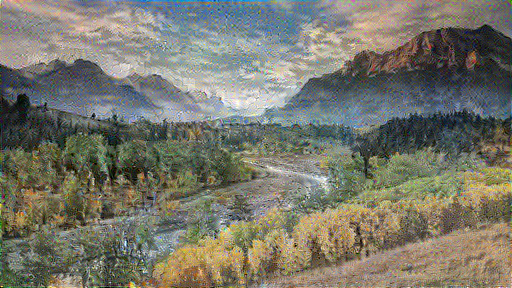

Train step: 1000
Total time: 119.8


In [35]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    mae_train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

#Modification 3: Adapting Total Variation Loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

In [36]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

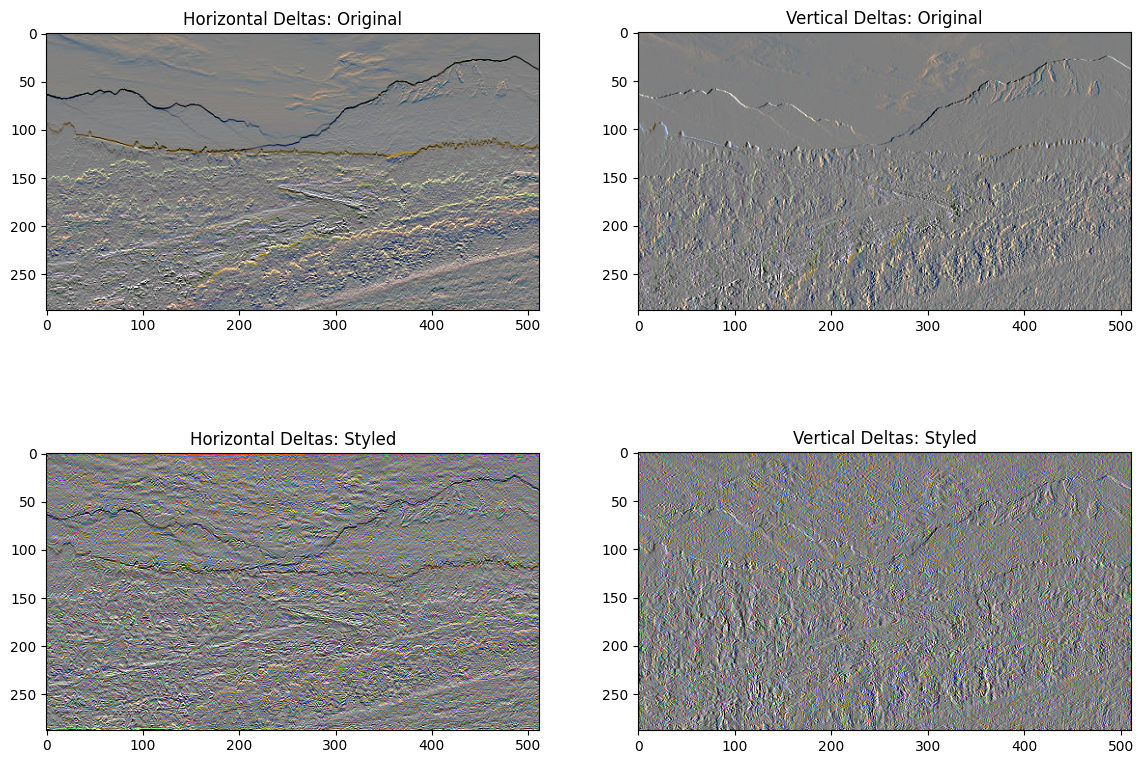

In [37]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

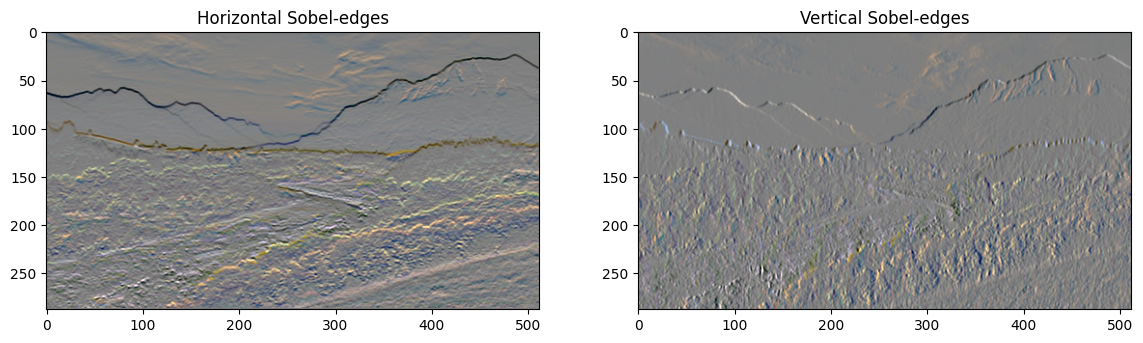

In [38]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [39]:
print("Variation Loss: ",tf.image.total_variation(image).numpy()[0])

Variation Loss:  70018.89


##Re-running Optimization

In [44]:
total_variation_weight=5

In [45]:
@tf.function()
def final_train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = mae_style_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [46]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

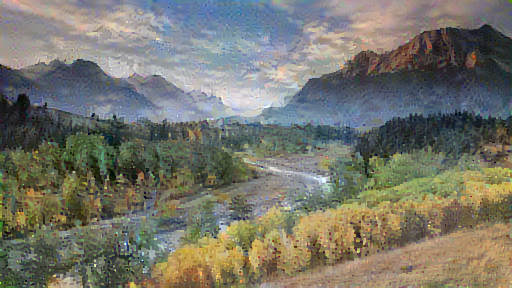

Train step: 1000
Total time: 111.1


In [47]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    final_train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Adding variation loss to the loss function results in a much smoother image with minimal artifacts. This is our final modification.

#Evaluation Metrics

##Total Content Loss, Cumulative Style Loss, and Variation Loss

These are the different components of the losses that we use in our loss function. We display the final values of the same after image generation.

In [48]:
content_outputs = extractor(image)['content']
content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
normalised_content_loss = content_loss/num_content_layers

style_loss = 0
style_outputs = extractor(image)['style']
for i in range(len(matrices)):
  style_loss += tf.add_n([tf.reduce_mean(abs(style_outputs[name]-matrices[i][name])) for name in style_outputs.keys()])
normalised_style_loss = style_loss/num_style_layers

variation_loss = tf.image.total_variation(image).numpy()[0]
variation_loss_reference = tf.image.total_variation(content_image).numpy()[0]
variation_loss_difference = variation_loss - variation_loss_reference

In [49]:
print("Content loss: ", content_loss.numpy()[()])
print("Normalised content loss: ", normalised_content_loss.numpy()[()])
print("Cumulative style loss: ", style_loss.numpy()[()])
print("Normalised style loss(per layer): ", normalised_style_loss.numpy()[()])
print("Variation loss: ", variation_loss)
print("Variation loss of content image: ", variation_loss_reference)
print("Variation loss difference: ", variation_loss_difference)

Content loss:  8.2406435
Normalised content loss:  8.2406435
Cumulative style loss:  21823008.0
Normalised style loss(per layer):  4364601.5
Variation loss:  22562.371
Variation loss of content image:  28104.113
Variation loss difference:  -5541.742


##Structural Similarity Index

In [50]:
from skimage.metrics import structural_similarity as compare_ssim
from skimage import img_as_float

array1 = img_as_float(np.array(tensor_to_image(content_image)))
array2 = img_as_float(np.array(tensor_to_image(image)))

# Ensure images have the same dtype for comparison
array1 = array1.astype(float)
array2 = array2.astype(float)

# Convert images to grayscale if they are in color
if array1.shape[-1] == 3:
    array1 = array1.mean(axis=-1)
if array2.shape[-1] == 3:
    array2 = array2.mean(axis=-1)

# Calculate SSI
ssi_index, _ = compare_ssim(array1, array2, full=True)

print("Structural Similarity Index:", ssi_index)

Structural Similarity Index: 0.62260692464762


#Modification 4
*Hasn't been tested due to time constraints*

The idea is to remove the outliers in each feature of each gram matrix over multiple images, and then average over each feature to get the best representation of the most similar gram matrix from all the style images. This code in its raw form is too computationally expensive and requires adequate parallelization. Due to time constraint, I was not able to successfully conduct this. However, this can be considered as a future modification.

In [ ]:
# aggregate = {}

# for layer in style_layers:
#   aggregate[layer] = []

# for matrix in matrices:
#   for layer in style_layers:
#     aggregate[layer].append(matrix[layer])

In [ ]:
# from scipy import stats
# import tensorflow as tf
# import numpy as np

# average = {}
# # for key in aggregate.keys():
# #   average[key] = tf.Variable(tf.zeros(aggregate[key][0].shape, dtype=tf.float32))  # Ensure dtype is specified

# for key in tqdm(aggregate.keys()):
#   empty_array = np.empty(aggregate[key][0].shape)
#   for i in tqdm(range(aggregate[key][0].shape[1])):
#     for j in range(aggregate[key][0].shape[2]):
#       ls = []
#       bs = []
#       for matrix in aggregate[key]:
#           ls.append(matrix[0][i][j])

#       z = np.abs(stats.zscore(ls))
#       threshold = 3
#       outliers = np.where(z > threshold)[0]  # Extract values from the tuple

#       # Remove outliers from the list
#       ls = [num for idx, num in enumerate(ls) if idx not in outliers]

#       # Check if the list is not empty before calculating the average
#       if ls:
#           avg = sum(ls) / len(ls)
#       else:
#           avg = 0.0  # or any other default value if the list is empty

#       # Update the tensor using TensorFlow operations
#       empty_array[0][i][j] = avg  # Accumulate the average
#     average[key] = tf.constant(empty_array)


In [ ]:
# style_target=average

##Re-running Optimization

In [ ]:
# opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
# style_weight=1e-2 # 1e-2
# content_weight=1e4

In [ ]:
# def style_content_loss(outputs):
#     style_outputs = outputs['style']
#     content_outputs = outputs['content']
#     style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
#     style_loss *= style_weight / num_style_layers

#     content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
#                              for name in content_outputs.keys()])
#     content_loss *= content_weight / num_content_layers
#     loss = style_loss + content_loss
#     return loss

In [ ]:
# @tf.function()
# def train_step(image):
#   with tf.GradientTape() as tape:
#     outputs = extractor(image)
#     loss = style_content_loss(outputs)

#   grad = tape.gradient(loss, image)
#   opt.apply_gradients([(grad, image)])
#   image.assign(clip_0_1(image))

In [ ]:
# import time
# start = time.time()

# epochs = 10
# steps_per_epoch = 100

# step = 0
# for n in range(epochs):
#   for m in range(steps_per_epoch):
#     step += 1
#     train_step(image)
#     print(".", end='', flush=True)
#   display.clear_output(wait=True)
#   display.display(tensor_to_image(image))
#   print("Train step: {}".format(step))

# end = time.time()
# print("Total time: {:.1f}".format(end-start))

#Modification 5

The idea is that some artist have a characteristic stroke/drawing style, while some have characteristic colour usage. The idea is to utilize the most recurring of the above factors and give higher weighting to it. In essence, separating the style vector to a texture and colour vector and including that in the overall model. The same Gram matrix is used to isolate style:

The idea here is to gauge the similarity in the features of each style images's gram matrix. More weightage is given to more similar features as they often represent the style.

#Model Limitations and Future Improvements

*I have divided my ideas for future works in 2 categories: *<br>
1. Modifications in present workflow
2. Modifications in workflow design

Please find more information in my [documentation document](https://docs.google.com/document/d/1398eeXx16g9dlEWAKq-J3oK-iT1ju6ES5Nnnjr7TGvM/edit).

##Modifications in the Present Workflow

1. Size modifications(now it is max(x,y)=512 and according to (ratio-based) resizing of min(x,y))
2. Pretrained model change
3. Change in the layers chosen for understanding style and content
4. Gram Matrix calculation to represent style
5. Averaging of gram matrices
6. Change in the weighting of loss function
7. Texture and colour styles separation
8. Change optimisers
9. Change style/content vector weights
10. Total variation loss regularisation
11. Edge detection to improve
12. Change in Variation Weight
13. Plot the style loss, content loss and variation loss over various epochs to visualise it, can also store the image after bunch of epochs


##Modifications in Workflow Design

1.
Learn style-specific features from the CNN training with relevant datasets. Make a composite image with all relevant learned features specific to the artist. Feed it to a “Neural Style Transfer” algorithm(takes 1 input and 1 style image as input. Output is the stylized image)
<br><br>
2.
Get a dataset with 2 labels:- object, and artist. Use feature disentanglement to maximize inter-artist loss and minimize inter-object loss. This will promote the model to learn style or artist-specific features as opposed to object-specific features while preserving some content originality.<br><br>
3.
Isolate different style vectors: 1 for grayscale image(focused on texture and not colour), and 1 from RGB focused entirely colour and its spatial distribution<br><br>
4.
Create an architecture for image generation from artist works with a loss function which minimises style loss and maximises content loss. Feed this image into the neural style transfer algorithm<br><br>
5.
Use some kind of clustering/data analysis methods to find a weighting scheme for averaging gram matrices(similar matrices have more weights and outliers are removed)<br><br>
6.
Instead of minimising style loss with respect to average gram matrix, minimise style loss with all the gram matrices. Probably not a good idea to use MSE to penalise outliers, instead compute similarity scores and try to match the styles closest to the content image<br><br>
7.
Content image based modifications in code. Differential weighting of content and style loss vectors depending on the drawing style of artist(For ex: whether there is focus on stricter artifact representation, or smoother, often merging landscape paintings)<br><br>
8.
Defining and using metrics to find similarity between all the gram matrices, giving higher weightage to a more common style representation. Usage of Cosine similarity between gram matrixes.<br><br>

